# Tutorial: Spectral Fitting

Adapted from "Analysis Workflow: Spectral Fitting" in the Fermi GBM Data Tools documentation.

Often, we would like to perform a spectral fit of GBM data, but this process can be somewhat complicated. We need to download multiple types of data, generate a good background fit, complete a fit of our source spectrum, and then examine the results of our fit. The following workflow will guide you through a simple example of this process.

In this tutorial, we will go through an example of how to use the Fermi Gamma-Ray Tools (GDT) toolkit as well as the core GDT toolkit to fit spectral data from the Fermi Gamma-ray Burst Monitor. 

In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import gdt.missions.fermi 
import gdt.core 

We will start our spectral fitting process by generating the lightcurves and count spectra of the data, background fits, and source selection ranges from multiple detectors. To do this, we will be using CSPEC data. We can download this data from NASA's High Energy Astrophysics Science Archive Research Center (HEASARC) archive with the `TriggerFinder` class from the GDT Fermi toolkit. We will use event **160509374** as our example for the rest of this tutorial. Since we do not want data from detectors that didn't observe the event, we can list the detectors we want data from in the argument of the function to only download the data from those listed detectors.

In [30]:
from gdt.missions.fermi.gbm.finders import TriggerFinder
from gdt.core import data_path

# initialize TriggerFinder to pull data from event 160509374
# spec_finder = TriggerFinder('090926181')

# download cspec data files in .pha format from listed detectors 
# filepaths = spec_finder.get_cspec(download_dir=data_path.joinpath('090926181'), dets=['n0','n1','b0'])

### Definiendo los paths a mano
object_no = '090926181'
object_name = f'bn{object_no}'
common_str = f'datos/{object_no}/glg_cspec_'
filepaths = [
    f"{common_str}b0_{object_name}_v00.pha"
    , f"{common_str}n0_{object_name}_v00.pha"
    , f"{common_str}n1_{object_name}_v00.pha"
]

Now we need to open and read our downloaded data. We can use the `GmbPhaii` class from the GDT Fermi toolkit to do so.

In [31]:
from gdt.missions.fermi.gbm.phaii import GbmPhaii

# open the downloaded data
cspec_b0=GbmPhaii.open(filepaths[0])
cspec_n0=GbmPhaii.open(filepaths[1])
cspec_n1=GbmPhaii.open(filepaths[2])

If you would like to see a first look of the downloaded data plotted as a lightcurve or count spectrum, you can do so with the `Lightcurve` or `Spectrum` classes from the GDT Core toolkit. Below is one example of this using data from one detector:

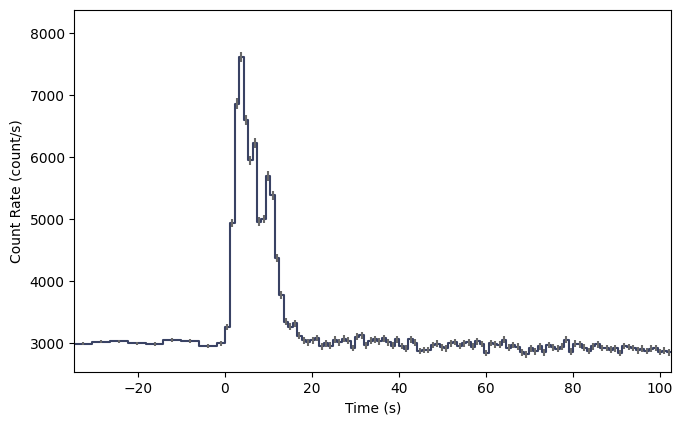

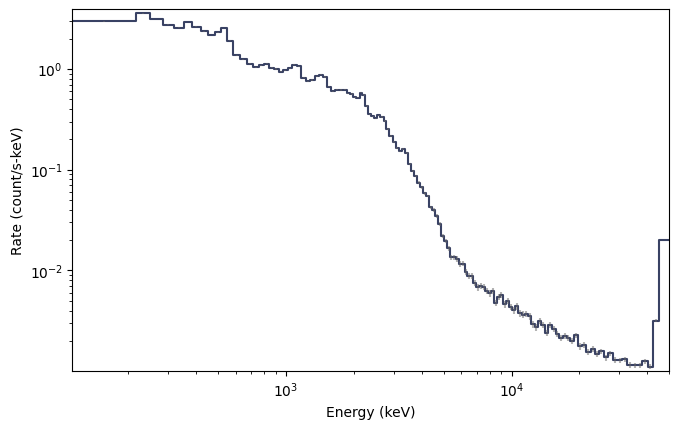

In [7]:
from gdt.core.plot.lightcurve import Lightcurve
from gdt.core.plot.spectrum import Spectrum

# create and show a plot of the lightcurve using data from the b0 detector
lightcurve_b0 = Lightcurve(data=cspec_b0.to_lightcurve(time_range=(-33,102)))
plt.show(lightcurve_b0)

# create and show a plot of the count spectrum using data from the b0 detector
specplot_b0 = Spectrum(data=cspec_b0.to_spectrum(time_range=(-33,102)))
plt.show(specplot_b0)

Because we want to fit the data from multiple detectors and don't want to have to repeat repeatedly plug data from many different detectors into the code over and over again, we can use the `GbmDetectorCollection` class to group data together in a "collection." This will reduce the amount of repetitive work we need to do by operating on all the collection items simultaneously. 

In [8]:
from gdt.missions.fermi.gbm.collection import GbmDetectorCollection

# group data from multiple detectors together in a "collection"
cspecs = GbmDetectorCollection.from_list([cspec_b0, cspec_n0, cspec_n1])

Now we can select the time and energy ranges of the data that we want to look at. Note that the background time range should usually be roughly twice the size of the source time range on either side. Also note that since we are using both the NaI detectors and BGO detectors, we need to use the appropriate energy ranges for both detectors. The energy ranges listed below are typically those recommended, as they allow us to eliminate some of the "overflow" zones at the edges of the detection ranges.

In [9]:
view_range=(-33,102) # source range - the time range that we want to zoom in on
bkgd_range=[(-550, -300), (675, 1000)] # background range - the time range where we are observing only the background radiation
energy_range_nai=(8,900) # energy range for the NaI detectors
energy_range_bgo=(325,35000) # energy range for the BGO detectors
src_range=(14,17) # source range - the time range during which the actual burst/event occurs

Now we must create our background fits. We can use the `BackgroundFitter` and `Polynomial` classes to perform a polynomial fit of the background radiation. We can create a background fitter for each detector’s data and add the fitters to their own collection, making sure that we tag the background fitters to correspond to the correct detectors. So, when we perform the fit, instead of having to call `backfitter.fit()` for each background fitter, we can call that method on the collection and it will perform the operation on every item inside it. 

In [10]:
from gdt.core.background.fitter import BackgroundFitter
from gdt.core.background.binned import Polynomial

# initialize the background fitters and add them to the collection, making sure the collection knows which background goes to which detector
backfitters = [BackgroundFitter.from_phaii(cspec, Polynomial, time_ranges=bkgd_range) for cspec in cspecs]
backfitters = GbmDetectorCollection.from_list(backfitters, dets=cspecs.detector())

We must select an order of polynomial to use for the background fit. It is recommended to start with low order fits (0, 1, etc.) and work your way up if those are not sufficient. 

In order to see the quality of your background fit, you can plot the graph of the energy vs. the fit's chi squared statistic over its degrees of freedom. A graph that is flatter and has a Chisq/DoF closer to 1 generally means that you have a better fit. If you are not sure what statistic your fit is returning when you call `backfitters.statistic()`, you can call `backfitters.statistic_name()` to find out.

Below is one example of this using data from one detector, but this can be done with data from any detector in your collection by changing the index. 

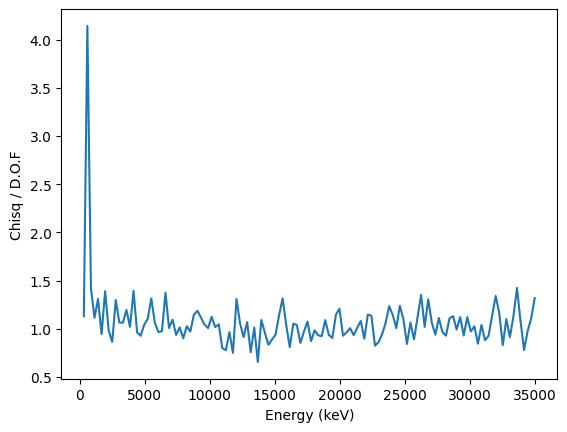

In [11]:
# perform the background fit, selecting an order of polynomial to do so
backfitters.fit(order=0)

# calculate chi squared over the degrees of freedom for the first detector in the collection (the b0 detector)
chisq_dof_b0 = backfitters.statistic()[0]/backfitters.dof()[0]

# plot the energy vs. chisq/dof graph, where the energy is our selected energy range for the BGO detectors
plt.xlabel("Energy (keV)")
plt.ylabel("Chisq / D.O.F")
bgfit_b0=plt.plot(np.linspace(energy_range_bgo[0],energy_range_bgo[1],len(chisq_dof_b0)), chisq_dof_b0)
plt.show(bgfit_b0)

After performing the fit, we can interpolate each background fitter over an array of times. The array of times we use is actually just the bin times from the first CSPEC file we added to the collection. This is fine because all our data are binned to the same bin edges. Then, we can add these interpolated backgrounds to their own collection.

In [12]:
# interpolate the fits
bkgds = backfitters.interpolate_bins(cspecs.data()[0].tstart, cspecs.data()[0].tstop)

# store the background fits in a collection
bkgds = GbmDetectorCollection.from_list(bkgds, dets=cspecs.detector())

Now we can apply the selections we made with our time and energy ranges and create our detailed lightcurves and count spectra. Since we nee to be aware of our different detectors, the `nai_args`, `nai_kwargs`, and corresponding bgo arguments allow us to specify arguments and keywords to be passed to either NaI or BGO detectors. Something like the `time_range` is the same for both detector types, so we pass it like a normal keyword as the object method expects, but `energy_range` is detector-type-dependent, since we usually want different energy ranges for the different types of detectors. 

In [13]:
# the lightcurves:
data_lcs = cspecs.to_lightcurve(nai_kwargs={'energy_range':energy_range_nai}, bgo_kwargs={'energy_range':energy_range_bgo})
# the energy-integrated background:
bkgd_lcs = bkgds.integrate_energy(nai_args=energy_range_nai, bgo_args=energy_range_bgo)
# the source time selection:
src_lcs = cspecs.to_lightcurve(time_range=src_range, nai_kwargs={'energy_range':energy_range_nai}, bgo_kwargs={'energy_range':energy_range_bgo})

# the count spectra:
data_specs = cspecs.to_spectrum(time_range=src_range)
# the time-integrated background: 
bkgd_specs = bkgds.integrate_time(*src_range)
# the energy selection: 
src_specs = cspecs.to_spectrum(time_range=src_range, nai_kwargs={'energy_range':energy_range_nai}, bgo_kwargs={'energy_range':energy_range_bgo})

Now we can plot our detailed lightcurves and count spectra with the `Spectrum` and `Lightcurve` classes that we mentioned earlier in this tutorial. Using the collections we created, we can plot the lightcurve and count spectrum for each detector in very few lines of code. 

What you see below are the lightcurves and corresponding count spectra for five data files. In this example, the lightcurves are represented by dark lines (with errorbars on each bin), the backgrounds are represented by red lines, and the source selections are represented by orange shaded regions. 

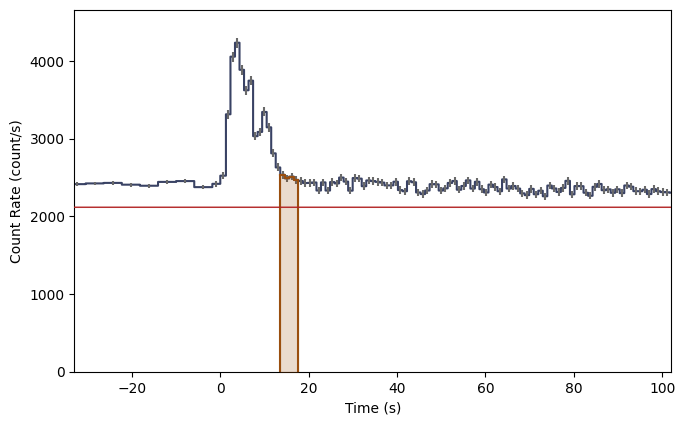

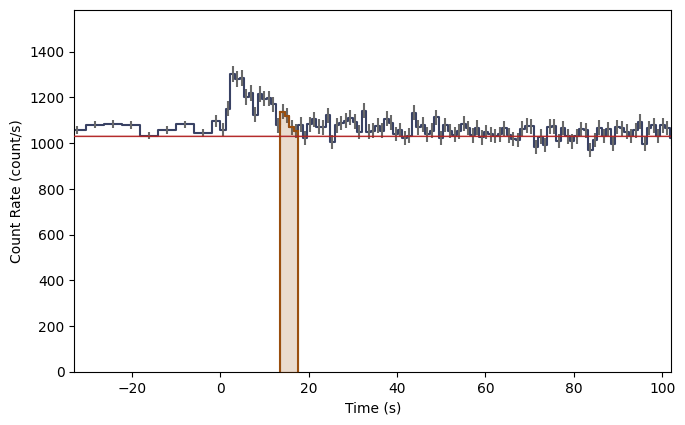

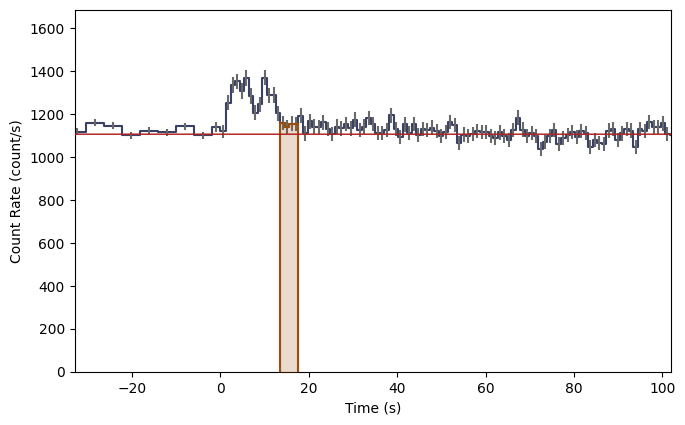

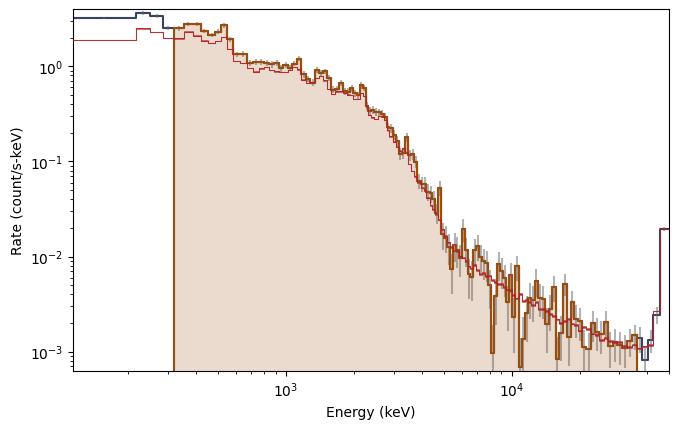

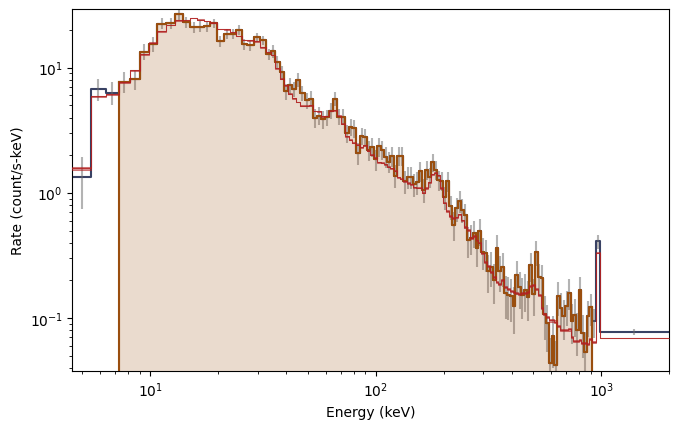

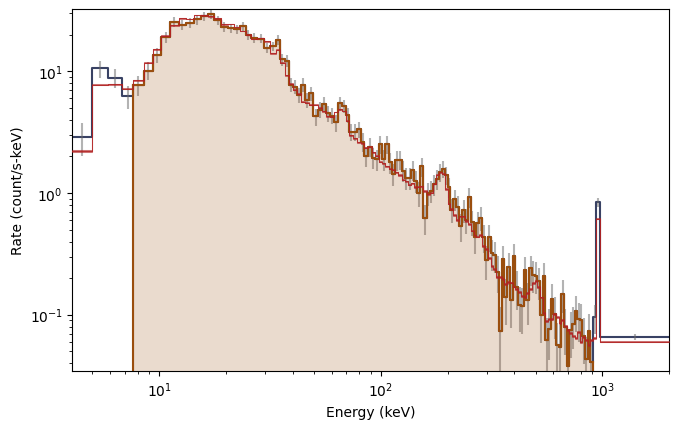

In [14]:
%matplotlib inline
from gdt.core.plot.lightcurve import Lightcurve
from gdt.core.plot.spectrum import Spectrum

# plot the lightcurves, including source selections and background fits
lcplots = [Lightcurve(data=data_lc, background=bkgd_lc) for data_lc, bkgd_lc in zip(data_lcs, bkgd_lcs)]
_ = [lcplot.add_selection(src_lc) for lcplot, src_lc in zip(lcplots, src_lcs)]
# zoom in to the view range on the lightcurves
for lcplot in lcplots:
    lcplot.xlim = view_range

# plot the count spectra, including source selections and background fits
specplots = [Spectrum(data=data_spec, background=bkgd_spec) for data_spec, bkgd_spec in zip(data_specs, bkgd_specs)]
_ = [specplot.add_selection(src_spec) for specplot, src_spec in zip(specplots, src_specs)]

Now we will start generating fit parameters for the data. To do this, we will need both PHA objects and responses to put into the fitter. The PHA objects we need can be obtained by converting our CSPEC files from PHAII objects into PHA objects. 

In [15]:
# convert cspec files from phaii objects to pha objects
phas = cspecs.to_pha(time_ranges=src_range, nai_kwargs={'energy_range':energy_range_nai}, bgo_kwargs={'energy_range':energy_range_bgo})

Now to obtain our responses. For this example, we will be using RSP2 files and downloading them using the `TriggerFinder` class once again. Note that for the `get_rsp2` function, we must mark that `ctime=false` and `cspec=true` in order to only get CSPEC files. 

In [32]:
# initialize TriggerFinder to pull data from event 160509374 and download cspec data files in .rsp2 format from listed detectors
# spec_finder = TriggerFinder('160509374')
# filepaths = spec_finder.get_rsp2(download_dir=data_path.joinpath('160509374'), ctime=False, cspec=True, dets=['n0','n1','b0'])

### Definiendo los paths a mano
filepaths = [
    f"{common_str}b0_{object_name}_v00.rsp2"
    , f"{common_str}n3_{object_name}_v00.rsp2"
    , f"{common_str}n4_{object_name}_v00.rsp2"
]

Now we must open our data again, similarly to how we did previously with our CSPEC files in .pha format earlier in this tutorial, but using the `GbmRsp2` class instead of `GbmPhaii`. We also need to interpolate the files after we open them in order to get the DRMs in the center of the source window. 

In [33]:
from gdt.missions.fermi.gbm.response import GbmRsp2

# open the downloaded data
rsp_b0=GbmRsp2.open(filepaths[0])
rsp_n0=GbmRsp2.open(filepaths[1])
rsp_n1=GbmRsp2.open(filepaths[2])

# gather the downloaded data in a collection
rsps = GbmDetectorCollection.from_list([rsp_b0, rsp_n0, rsp_n1])

# interpolate the data at the central time
rsps_interp = [rsp.interpolate(pha.tcent) for rsp, pha in zip(rsps, phas)]

Now we can use the spectral fitting class `SpectralFitter` to fit our data. There are various derived classes of the `SpectralFitter` class that implement a specific likelihood function; for this example, we want to use Profile-Gaussian likelihood, and will thus be using the derived class `SpectralFitterPgstat`. The spectral fitter takes list objects (which is why we must convert the `bkgds` object to a list), and the method defined as `'TNC'` refers to the Truncated Newton algorithm, which performs optimization considering the boundaries and constraints on the parameters.

In [18]:
from gdt.core.spectra.fitting import SpectralFitterPgstat

# initialize the spectral fitter with the .pha files, backgrounds, and interpolated response files
specfitter = SpectralFitterPgstat(phas, bkgds.to_list(), rsps_interp, method='TNC')

Now we need to select a function to fit. The `gdt.core.spectra.functions` module contains a listing of functions with a variety of metadata attached to them. For each parameter of a function, you can set basic defaults (like in XSPEC), such as the starting guess values for parameters, their min/max bounds, and if they are fixed or free to be fit. This allows them to be used with the more complex algorithms like TNC. For this example, we will use the `Band` function. You can easily see the parameters, their default values, minimum/maximum allowable values, and more after importing the function. 

In [19]:
from gdt.core.spectra.functions import Band

# initialize the comptonized function
band = Band()

# view the list of parameters, their default values, their minimum and maximum values, etc. 
print(band.param_list)
print(band.default_values)
print(band.min_values)
print(band.max_values)

[('A', 'ph/s/cm^2/keV', 'Amplitude'), ('Epeak', 'keV', 'SED Peak'), ('alpha', '', 'Low-Energy Photon index'), ('beta', '', 'High-Energy Photon index'), ('Epiv', 'keV', 'Pivot energy')]
[0.01, 500.0, -0.5, -2.5, 100.0]
[1e-10, 0.01, -1.9, -10.0, 0.01]
[inf, inf, 20.0, -2.0001, inf]


Now, finally, we can do the fit. We can also print out some relevant info to make sure the fit succeeded, and if it did, we can quickly access things like the best-fit parameters and parameter uncertainties at the xx% confidence level resulting from `-2(Delta)LogLike`. 

In [20]:
# perform the fit and see if it converged
print('Band Fit:')
specfitter.fit(band, options={'maxiter': 1000})
print(specfitter.message)

# show the maximum likelihood parameter values
print('Parameters: {}'.format(specfitter.parameters))

# show errorbar values on either side of the parameters with 90% confidence interval
print('90% Asymm. Errors:\n {}'.format(specfitter.asymmetric_errors(cl=0.9)))

# show the fit statistic and degrees of freedom
print('Pgstat/DoF: {}/{}'.format(specfitter.statistic, specfitter.dof))

Band Fit:
Max. number of function evaluations reached
Parameters: [ 1.60863584e-06  6.27412880e+02  1.06419663e+01 -2.00010000e+00]
90% Asymm. Errors:
 [[2.77222128e-07 3.36411488e-07]
 [9.68814997e+00 1.09549645e+01]
 [2.27319978e-01 2.36592151e-01]
 [1.61696611e-01 0.00000000e+00]]
Pgstat/DoF: 218.6667769972389/358


/home/user/.cache/pypoetry/virtualenvs/astrogrb-3I3v3uRS-py3.13/lib/python3.13/site-packages/gdt/core/spectra/fitting.py:371: UserWarning: Parameter exists at its upper bound
  warnings.warn("Parameter exists at its upper bound")


Congrats! We’ve successfully completed our first fit! It converged, and we printed out (in ugly print) the maximum likelihood parameter values and 90% confidence uncertainties, which are calculated from the shape of the likelihood surface. We also output the fit statistic and the fit's degrees of freedom.

This is nice, but as always, a plot is worth a 1000 words. We can use the `ModelFit` class to view the fit:

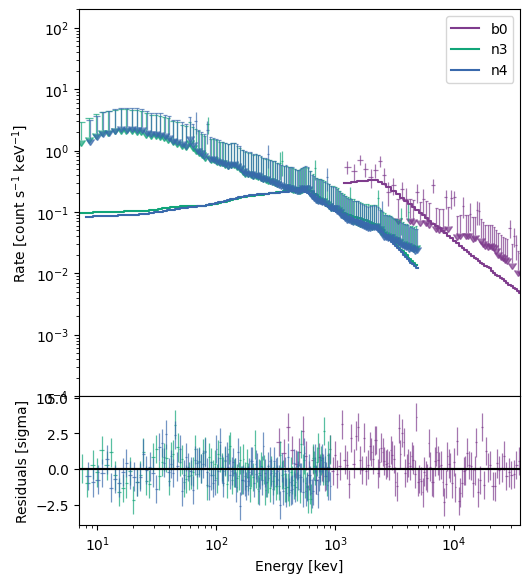

In [21]:
from gdt.core.plot.model import ModelFit

# initialize with your spectral fitter once the fit is done
modelplot = ModelFit(fitter=specfitter)

# we need to zoom in on this particular plot, which is easy to do with the residuals temporarily hidden
ModelFit.hide_residuals(modelplot)
plt.ylim(1e-4,200)
plt.xlim(7.15,4000)
ModelFit.show_residuals(modelplot)

The default view of the model plot shows the fit of our Comptomized function to the count spectrum. The data is converted to upper limits based on the model variances.

If you’re feeling good about your fit, you can also switch views to plot the resulting photon, energy, or $νF_{ν}$ spectrum:

/home/user/.cache/pypoetry/virtualenvs/astrogrb-3I3v3uRS-py3.13/lib/python3.13/site-packages/gdt/core/spectra/fitting.py:603: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = multivariate_normal(self.parameters, self.covariance,


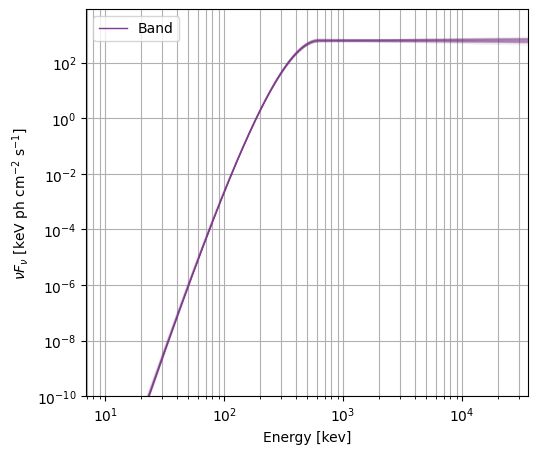

In [22]:
# show a plot of the νFν spectrum instead of the fit
modelplot_nu=ModelFit(fitter=specfitter, view='nufnu')
modelplot_nu.ax.grid(which='both')

The model plot samples from the covariance matrix to produce a density plot of the spectrum. A word of caution here: you don’t always have a valid covariance matrix that is symmetric and positive semi-definite (and will be alerted if this is the case), so you should investigate the parameter posteriors further, perhaps with MCMC or nested sampling.

You can quickly get the flux for the best-fit parameters using `comptonized.integrate()` or produce samples (again using the covariance matrix) using `specfitter.sample_flux()`:

In [24]:
# flux over 10-1000 keV
photon_flux = band.integrate(specfitter.parameters, (10.0, 1000.0)) # photons/s/cm^2
energy_flux = band.integrate(specfitter.parameters, (10.0, 1000.0), energy=True) # erg/s/cm^2
photon_flux,energy_flux

(np.float64(0.8750472631527274), np.float64(8.542292631445815e-07))

You can always rerun the fit with a different function if you want. Let’s have a little fun and perform a multi-component fit. Another feature of the functions are that you can elegantly add or multiply components into a single model.

In [25]:
from gdt.core.spectra.functions import Comptonized, PowerLaw

# we've defined a new model that is the sum of a Comptonized function and a power law
comp_pl = Comptonized() + PowerLaw()

# rerun the fit
print('Comp+PL Fit:')
specfitter.fit(comp_pl, options= {'maxiter': 1000})

print(specfitter.message)
print('Parameters: {}'.format(specfitter.parameters))
print('Pgstat/DoF: {}/{}'.format(specfitter.statistic, specfitter.dof))

Comp+PL Fit:
Max. number of function evaluations reached
Parameters: [ 6.89017261e-05  8.99312035e+02  4.00540089e+00  9.81970850e-05
 -1.89505185e+00]
Pgstat/DoF: 241.82281917885086/357


Cool, we can see the best fit parameters for that fit as well. What does the fit look like?

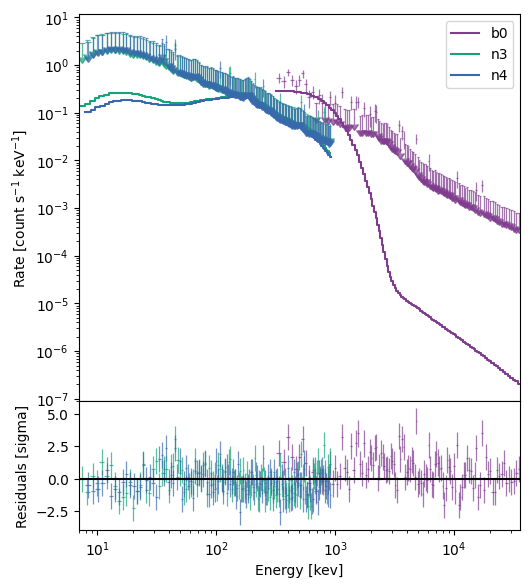

In [26]:
modelplot = ModelFit(fitter=specfitter)

To round it out, let’s just take a look at the $νF_{ν}$ spectrum.

/home/user/.cache/pypoetry/virtualenvs/astrogrb-3I3v3uRS-py3.13/lib/python3.13/site-packages/gdt/core/spectra/fitting.py:603: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = multivariate_normal(self.parameters, self.covariance,


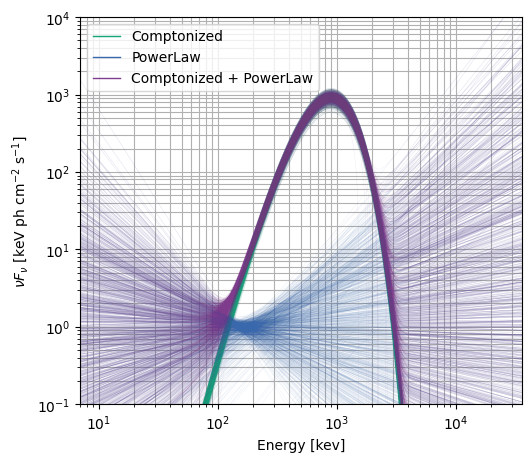

In [27]:
modelplot = ModelFit(fitter=specfitter)
# plot 1000 samples instead of the default 100
modelplot.nufnu_spectrum(num_samples=1000)
modelplot.ylim = (0.1, 10000.0)
modelplot.ax.grid(which='both')

And finally, to finish up the workflow, we can save the entire state of the fitter and fit results for later:

In [28]:
specfitter.save('./my_second_fit.npz')

This will save everything to a compressed numpy file, which can be loaded at any time with

In [29]:
restored_specfitter = SpectralFitterPgstat.load('./my_second_fit.npz')

Fit loaded from 2025-09-26 02:10:55


This concludes the workflow example for spectral fitting. 